In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FeedforwardNN():
    def __init__(self, structure):
        
        self._layers, self.act = list(zip(*structure))
        self._params = {}
        self.grad = {}
        self.a_dict = {
            "relu" : self.relu,
            "sigmoid" : self.sigmoid,
        }
        self.d_dict = {
            "relu" : self.d_relu,
            "sigmoid" : self.d_sigmoid
        }
        self.__init_weights()
        

    def __init_weights(self):
        self._params['W'] = {}
        self._params['B'] = {}
        for layer in (range(1, len(self._layers))):
            self._params['W'][layer] = np.random.rand(self._layers[layer], self._layers[layer-1])
            self._params['B'][layer] = np.random.rand(self._layers[layer], 1)
            
    def sigmoid(self, val):
        return 1.0/(1 + np.exp(-val))
    
    def d_sigmoid(self, val):
        return np.exp(-val) / (np.exp(-val)+1)**2
    
    def relu(self, val):
        return np.where(val > 0, val, 0)

    def d_relu(self, val):
        return np.where(val > 0, 1, 0)

    def softmax(self, val):
        exps = np.exp(val - val.max())
        return exps / np.sum(exps, axis=0)
    
    def d_softmax(self, val):
        exps = np.exp(val - val.max())
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
    
    def cross_entropy(self, predictions, targets, epsilon=1e-9):
        predictions = np.clip(predictions.squeeze(), epsilon, 1. - epsilon)
        
        N = predictions.shape[0]
        ce = -np.sum(targets*np.log(predictions))/N
        return ce
    
    def predict(self, X):
        '''
        The predict function.
        Input: 
        - X 
        Output:
        - Predicted class in the form of a softmax
        '''
        A = X.T
        for layer in range(1, len(self._layers)-1):
            Z = np.dot(self._params['W'][layer], A) + self._params['B'][layer]
            A = self.a_dict[self.act[layer]](Z)
        Z = np.dot(self._params['W'][len(self._layers)-1], A) + self._params['B'][len(self._layers)-1]
        A = self.softmax(Z)
        return A
    
    def forward(self, X):
        '''
        Forward propagation. Loops through all layers and calculates activations of each layer. The values are stored in 
        a variable called grad
        '''
        grad = {
            'A' : {},
            'Z' : {},
        }
        A = X.T
        grad['A'][0] = A
        
        for layer in range(1, len(self._layers)-1):
            Z = np.dot(self._params['W'][layer], A) + self._params['B'][layer]
            A = self.a_dict[self.act[layer]](Z)
            grad['A'][layer] = A
            grad['Z'][layer] = Z
        
        Z = np.dot(self._params['W'][len(self._layers)-1], A) + self._params['B'][len(self._layers)-1]
        A = self.softmax(Z)
        
        grad["A"][len(self._layers) - 1] = A
        grad["Z"][len(self._layers) - 1] = Z
        self.grad = grad
        
        return A
    
    def backwards(self, y_true):
        '''
        Backwards propagation. Loops through the layers in a reversed order and calculates the gradients of each layer.
        The gradients are stores in a dictionary. In the last network layer the ground truth and the prediction are
        compared.
        
        Input:
        - y_true: ground truth
        '''
        n_layers = len(self._layers)
        W = self._params['W']
        B = self._params['B']
        grad = self.grad
        
        gradients = {
            'Z' : {},
            'W' : {},
            'b' : {}
        }
        for layer in reversed(range(1,n_layers)):
            if layer == n_layers-1:
                dZ = grad['A'][n_layers-1].reshape(grad['Z'][n_layers-1].shape) - y_true.reshape(grad['Z'][n_layers-1].shape)
            else:
                dZ = np.dot(W[layer+1].T, dZ) * self.d_dict[self.act[layer]](grad['Z'][layer])
            
            dW = np.dot(dZ, grad['A'][layer-1].T)
            db = dZ
            
            gradients['Z'][layer] = dZ
            gradients['W'][layer] = dW
            gradients['b'][layer] = db
        self.gradients = gradients
        return gradients
    
    def optimize(self, lr):
        '''
        Loops over the layers of the network and updates the weights and biases in each layer based on gradients
        from backprop and learning rate.
        
        Input:
        - lr : learning rate
        '''
        for layer in range(1, len(self._layers)):
            before = self._params['W'][layer].copy()
            self._params['W'][layer] -= lr * self.gradients['W'][layer]
            self._params['B'][layer] -= lr * self.gradients['b'][layer]
    
    def reset_gradients(self):
        '''
        Simply resets the gradients of the model
        '''
        self.gradients = {}
        
    def train(self, data, labels, n_epochs, lr=0.01, verbose=False):
        '''
        Neural network training procedure. Will loop over the training data for n_epochs times. For each training
        example it will update the weights based on the gradients from backprop and the learning rate. 
        Additionally we keep the loss during all epochs for visualisation purposes.
        
        Input:
        - data
        - labels
        - n_epochs : number of training epochs
        - lr : learning rate (default = 0.01)
        
        Output:
        - A list containing the averaged error for each epoch
        '''
        print("--- Training started---")
        error = []
        for epoch in range(n_epochs):
            epoch_loss = 0
            for x, y in zip(data,labels):
                
                pred = self.forward(x)
                epoch_loss = epoch_loss + self.cross_entropy(pred, y)
                self.backwards(y)
                self.optimize(lr)
                
            error.append(epoch_loss / len(labels))
            if verbose:
                print(f"--- Epoch {epoch+1} complete == loss: {epoch_loss/len(labels)}---")
                
        print("--- Training ended---")
        return error

## XOR OneHot example:


In [3]:
simpleNet = FeedforwardNN([(2,"relu") ,(9,"relu"), (2,"relu")])

# XOR function
data = [np.array([[0,0]]), np.array([[0,1]]), np.array([[1,0]]), np.array([[1,1]])]
labels = [np.array([[0,1]]), np.array([[1,0]]), np.array([[1,0]]), np.array([[0,1]])]

error = simpleNet.train(data, labels, 1000, lr=0.1)


--- Training started---
--- Training ended---


In [4]:
# TP example
pred = simpleNet.predict(np.array([[1,1]])).reshape(2,)
loss = simpleNet.cross_entropy(pred, np.array([[0,1]]))

print(pred)
print(loss)
print("Low loss when prediction is correct")

[0.00109975 0.99890025]
0.0005501774661700688
Low loss when prediction is correct


In [5]:
# TN example
pred = simpleNet.predict(np.array([[1,1]])).reshape(2,)
loss = simpleNet.cross_entropy(pred, np.array([[1,0]]))

print(pred)
print(loss)
print("High loss when prediction is wrong")

[0.00109975 0.99890025]
3.4063363062382273
High loss when prediction is wrong


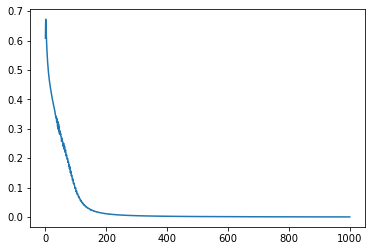

In [6]:
plt.plot(error)

In [7]:
def encodeData(data, max_size=500):
    '''
    Function used for OneHot encodings
    
    Input:
    - Data in the form list of numbers.
    
    Output:
    - List where entries now are onehot encoded.
    '''
    res = np.zeros((data.size, max_size))
    res[np.arange(data.size),data] = 1
    return res

# Quick learning visualization

Here is a quick example showing that the model is learning quickly.

Learning using the ReLU goes very quickly but is for some reason a little unstable. I have not been able to figure out what is the reason behind this.

Learning using the sigmoid is very stable and we get a nice learning curve

In [8]:
from sklearn import datasets

iris = datasets.load_iris()
X = list(iris.data)
X = [np.array([x]) for x in X]
y = list(encodeData(iris.target, 3))
y = [np.array([i]) for i in y]


--- Training started---
--- Training ended---


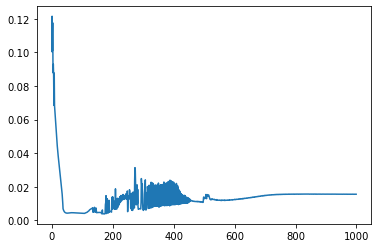

In [9]:
nn = FeedforwardNN([(4,"does nothing"),(24, "relu"),(3,"does nothing")])
error = nn.train(X,y, 1000)
plt.plot(error)

--- Training started---
--- Training ended---


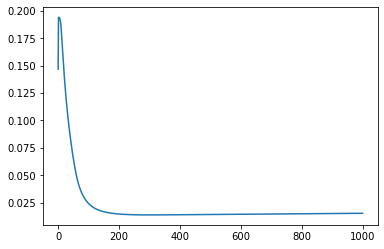

In [10]:
nn = FeedforwardNN([(4,"does nothing"),(24, "sigmoid"),(3,"does nothing")])
error = nn.train(X,y, 1000)
plt.plot(error)


## Embeddings

In [11]:
import tensorflow as tf
import re
from string import punctuation
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [12]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [13]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
def getData(vocab_size = 500, path_to_file = path_to_file):
    '''
    Function to creates out vocabulary, and separates our data into training examples. 
    It also makes sure that the words in the training data are in the vocab.
    Input:
    - Vocab_size: How large is your vocab (default 500 for quick learning)
    - Path_to_file: Path to the dataset file, in this case shakespeare
    
    Output:
    - V: Vocab
    - X: Training data
    - y: Training labels
    '''
    
    with open(path_to_file, encoding='utf-8') as f: 
        data = f.read()
    f.close()
    
    data = data
    
    stoplist = set(list(punctuation) + ["--"])
    tokens = [token for token in nltk.word_tokenize(data.lower()) if token not in stoplist]
    
    count = Counter(tokens)
    vocab = [ x for (x,y) in count.most_common(vocab_size)]
    
    data_ngrams = list(ngrams(tokens, 4))
    
    # Checks that all words are in vocab.
    in_vocab = [ngram for ngram in data_ngrams if all([x in vocab for x in ngram])]

    X = [example[:3] for example in in_vocab]
    y = [example[-1] for example in in_vocab]
    return vocab, X, y
    
#vocab_size = 1024
#v, X, y = getData(vocab_size=vocab_size)

In [14]:
import tensorflow as tf
path_1 = tf.keras.utils.get_file('mobydick.txt', 'https://www.gutenberg.org/files/2701/2701-0.txt')
path_2 = tf.keras.utils.get_file('huckleberry.txt', 'https://www.gutenberg.org/files/76/76-0.txt')


def combine_files(files, output_path):
    with open(output_path, 'w', encoding='utf-8') as outfile:
        for fname in files:
            with open(fname, encoding='utf-8') as infile:
                for line in infile:
                    outfile.write(line)

combine_files([path_1, path_2], "books_combined.txt")
vocab_size = 1024
v, X, y = getData(vocab_size=vocab_size, path_to_file="books_combined.txt")

In [15]:
print(X[:4])
print(y[:4])
print(len(X))

[('or', 'the', 'whale'), ('is', 'for', 'the'), ('for', 'the', 'use'), ('in', 'the', 'united')]
['by', 'use', 'of', 'states']
132091


In [16]:
# Here we create mappings from words to ints and back. This is used when creating embeddings
word_to_int = {}
int_to_word = {}
for i, word in enumerate(v):
    word_to_int[word] = i
    int_to_word[i] = word

In [17]:
# In this case 64 dimensions
model = FeedforwardNN([(vocab_size,"does nothing"),(64, "sigmoid"),(64, "sigmoid"),(64, "sigmoid"),(vocab_size,"does nothing")])

In [18]:

def training_procedure(model, X, y, epochs, vocab_size, combine = False, verbose=False, lr=0.01):
    '''
    For each training example, encode it and its label
    Feed this new encoded dataset into out model.
    '''
    n_examples = len(y)
    
    onehot_data = []
    onehot_labels = []
    
    if not combine:
        for context, label in zip(X,y):
            converted = np.asarray([word_to_int[word] for word in context])
            encoded_data = encodeData(np.asarray(converted), vocab_size).reshape(1,3*vocab_size)
            encoded_label = encodeData(np.asarray(word_to_int[label]), vocab_size)

            onehot_data.append(encoded_data)
            onehot_labels.append(encoded_label)
    else:
        for context, label in zip(X,y):
            converted = np.asarray([word_to_int[word] for word in context])
            encoded_data = np.sum(encodeData(np.asarray(converted), vocab_size), axis=0).reshape(1, vocab_size)
            encoded_label = encodeData(np.asarray(word_to_int[label]), vocab_size)

            onehot_data.append(encoded_data)
            onehot_labels.append(encoded_label)
            
    
    return model.train(onehot_data, onehot_labels, epochs, lr=lr, verbose=verbose)
        
#error = training_procedure(model, X, y, 1, vocab_size, True)


In [19]:
weights = model._params['W'][len(model._params['W'])]
vocab = v

In [20]:
print(weights.shape)

(1024, 64)


In [21]:
import io
out_v = io.open('vectors_combined_5epochs.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata_combined_5epochs.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):

    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [24]:
vocab_size = 512
v, X, y = getData(vocab_size=vocab_size, path_to_file="books_combined.txt")

word_to_int = {}
int_to_word = {}
for i, word in enumerate(v):
    word_to_int[word] = i
    int_to_word[i] = word

model = FeedforwardNN([(vocab_size,"does nothing"),(64, "relu"),(64, "relu"),(64, "relu"),(vocab_size,"does nothing")])
error = training_procedure(model, X, y, 10, vocab_size, lr=0.2, combine = True, verbose=True)


--- Training started---
--- Epoch 1 complete == loss: 0.010061189609935304---
--- Epoch 2 complete == loss: 0.010069788207134268---
--- Epoch 3 complete == loss: 0.01006983726871644---
--- Epoch 4 complete == loss: 0.010069837228530302---
--- Epoch 5 complete == loss: 0.010069837018637466---
--- Epoch 6 complete == loss: 0.010069836945265155---
--- Epoch 7 complete == loss: 0.010069836922403999---
--- Epoch 8 complete == loss: 0.010069836915459448---
--- Epoch 9 complete == loss: 0.0100698369133649---
--- Epoch 10 complete == loss: 0.010069836912734597---
--- Training ended---


In [25]:
out_v = io.open('vectors_3hidden_10epochs_books_Svocab_VLlr.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata_3hidden_10epochs_books_Svocab_VLlr.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):

    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()